## **Introduction**

GANs are an interesting topic I have always wanted to play with. There are already many types of GANs, in general, a GAN consists of a discriminator and a generator, in which the generator makes new (fake) samples, and feed them to the discriminator, that has to detect whether if the sample is fake, or if it comes from the training dataset. 


<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/11000153/g1.jpg" width="600"></img>
<figcaption>GAN diagram, taken from https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/</figcaption>


After some reading I decided to use an 'AC-GAN', that stand for Auxiliar Classifier GAN. The main difference between the AC-GAN and a plain GAN, is that to train the AC-GAN we need both training samples, and training labels. These Training labels are fed to the generator, that will generate fake images using both the random noise, and the input label. The discriminator also has to predict the source of the image (i.e. if it is a fake image or not), and in the AC-GAN scenario, it also has to predict the label of the image.

For more detailed information, I recommend reading these papers:
*     Generative Adversarial Networks: https://arxiv.org/pdf/1406.2661.pdf
*     Conditional Image Synthesis with Auxiliary Classifier GANs: https://arxiv.org/pdf/1610.09585.pdf

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Using TensorFlow backend.


## AC-GAN implementation

Keras currently has no AC-GAN implementation out of the shelf, so after some googling, I came across [this](https://github.com/eriklindernoren/Keras-GAN/) nice repo, where there many GAN architectures implemented in Keras. One of the implemented architectures is the [AC-GAN](https://github.com/eriklindernoren/Keras-GAN/blob/master/acgan/acgan.py).
I made some changes in that implementation, this is a short summary of what these changes intended to do:
*   being able to train with more datasets than just standard mnist
*   showing samples of generated images during training
*   sampling images can be shown in cells, not only into files

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class ACGAN():
    def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100):
        # Input shape
        self.img_rows = input_rows
        self.img_cols = input_cols
        self.channels = input_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = input_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, X_train, y_train, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()
        #X_train, y_train = self.X_train, self.y_train

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Loss output
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            #show the final losses
            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
                #do not save model
                #self.save_model()
                self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

        return g_loss_epochs, d_loss_epochs
 

    #row, cols to be sampled
    def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #plt.figure(figsize=fig_size)
        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("../images/%d.png" % epoch)
        else:
            #plt.figure(figsize=fig_size)
            plt.show()
        plt.close()

    def sample_single_image(self, noise, label):
        gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')

    def save_model(self):

        def save(model, model_name):
            model_path = "../saved_model/%s.json" % model_name
            weights_path = "../saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            #
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

In [3]:
#label dictionary
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [4]:
#input dimensions
input_rows = 28
input_cols = 28
input_channels = 1

In [5]:
#load the data with the format needed in the AC-GAN implementation
def load_fashion_mnist(input_rows, input_cols, path='../input/fashion-mnist_train.csv'):
    #read the csv data
    df = pd.read_csv(path)
    #extract the image pixels
    X_train = df.drop(columns = ['label'])
    X_train = X_train.as_matrix()
    X_train = X_train.reshape(X_train.shape[0], input_rows, input_cols)
    #extract the labels
    y_train = df['label'].as_matrix()
    
    return X_train, y_train

In [6]:
X_train, y_train = load_fashion_mnist(input_rows, input_cols)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
X_train.shape, y_train.shape, type(X_train), type(y_train)

((60000, 28, 28), (60000,), numpy.ndarray, numpy.ndarray)

In [8]:
input_classes = pd.Series(y_train).nunique()

In [9]:
#the instance of the ACGAN class
#we can see the Discriminator and Generator architecture
fashion_acgan = ACGAN(input_rows, input_cols, input_channels, input_classes)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)         

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 [D loss: 3.472028, acc.: 39.00%, op_acc: 4.00%] [G loss: 3.436020]


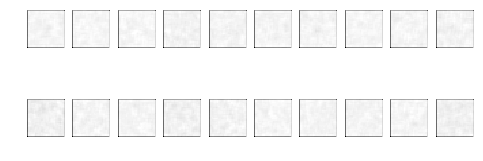

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 200 [D loss: 1.998863, acc.: 48.00%, op_acc: 48.00%] [G loss: 2.376393]


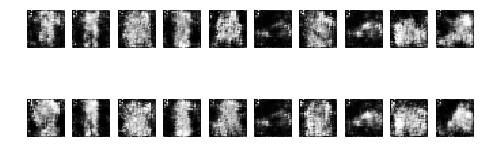

Epoch: 400 [D loss: 1.970664, acc.: 48.00%, op_acc: 41.50%] [G loss: 2.045204]


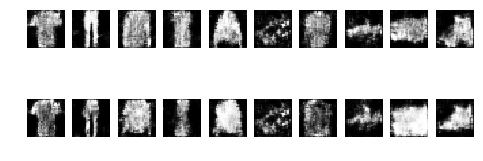

Epoch: 600 [D loss: 1.881617, acc.: 47.00%, op_acc: 43.00%] [G loss: 1.902558]


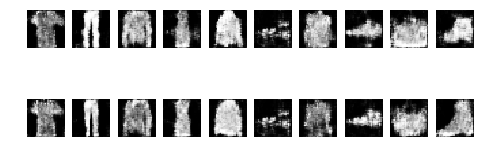

Epoch: 800 [D loss: 1.938504, acc.: 42.00%, op_acc: 42.50%] [G loss: 1.765125]


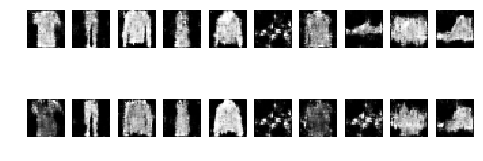

Epoch: 1000 [D loss: 1.775050, acc.: 57.00%, op_acc: 40.00%] [G loss: 1.739255]


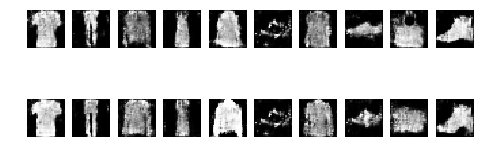

Epoch: 1200 [D loss: 1.811705, acc.: 51.50%, op_acc: 39.50%] [G loss: 1.745283]


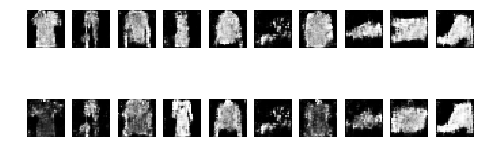

Epoch: 1400 [D loss: 1.831542, acc.: 52.00%, op_acc: 39.00%] [G loss: 1.824026]


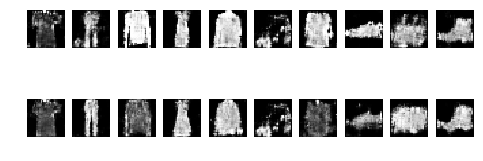

Epoch: 1600 [D loss: 1.779005, acc.: 54.50%, op_acc: 50.00%] [G loss: 1.753063]


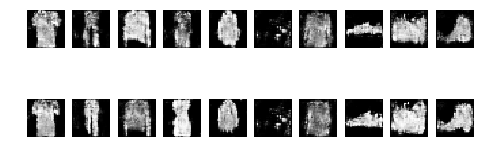

Epoch: 1800 [D loss: 1.730253, acc.: 55.00%, op_acc: 49.50%] [G loss: 1.918685]


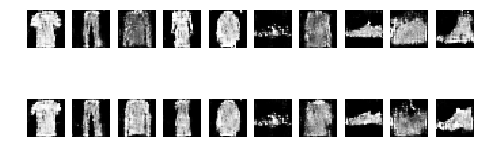

In [10]:
#Train the AC-GAN with the fashion-mnist data
g_loss, d_loss = fashion_acgan.train(X_train, y_train, epochs=2000, batch_size=100, sample_interval=200)

In the previous cell we train our AC-GAN with the fashion-mnist data. We can see that in the first 200 epochs the generator is doing a poor job, and outputs mainly noise. The output gets richer iteration after iteration, getting convincing results in the last training iterations.

In [11]:
#Show the Generator-Descriminator loss for every epoch
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

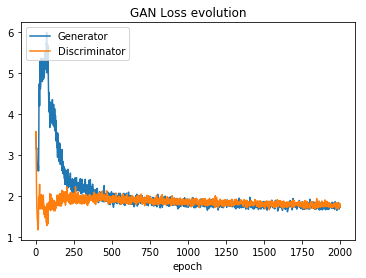

In [12]:
plot_gan_losses(g_loss, d_loss)

It can be seen that in the first epochs (first 200) the generator has huge loss values, while the discriminator has lower loss values, meaning that the generator is not being able to trick the discriminator yet. The loss for the generator decreases after some epochs, arriving to a stable point after epoch 700.

## Sample images from the final trained AC-GAN

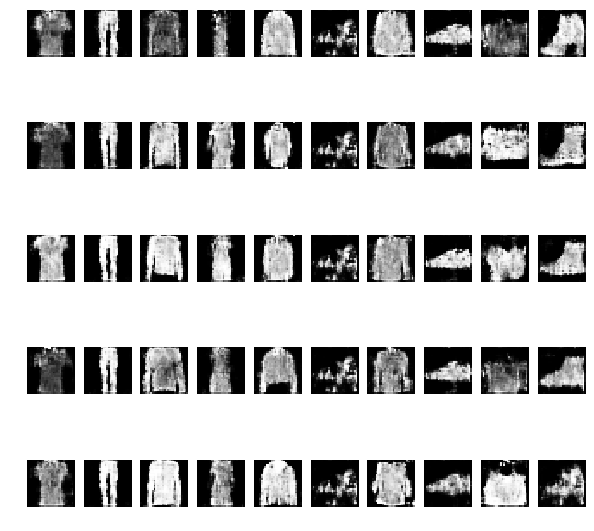

In [13]:
fashion_acgan.sample_images(0, smp_rows=5, smp_cols=10, save_img=False, fig_size=(10, 10))

Most classes we get interesting outputs, while for the 6th column (sandals) we get not so nice generated images. In the good side, it can also be seen intra-class variability, which is a good sign that the ac-gan is performing well.

## Generated images analysis

Two different tests will be done to the AC-GAN to asses the quality of the generated images:
*    Draw samples from interpolated points between two arbitrary points
*    Check the distance between generated images and training images

GANs that have 'overfit' show abrupt changes when there are small changes in the input noise. Well trained GANs should have more smooth output changes when are fed with slightly different input noise. The second check tries to asses if the AC-GAN has overfit to the training data, meaning that it will output a copy of input images. 

### Samples between interpolated points

In [14]:
# draw interpolated samples between two arbitrary points
def show_interp_samples(point1, point2, N_samples_interp, input_classes):
    #pick N_samples_interp + 2 points (one is the start, noise_1, and the other the end, noise_2)
    N_samples_interp_all = N_samples_interp + 2
    N_labs = input_classes
    plt.figure(figsize=(11,11))
    plt.plot([N_labs, N_samples_interp_all, (N_samples_interp_all * N_labs) + 1])
    
    #fit a line between point1 and point2
    line = interp1d([1, N_samples_interp_all], np.vstack([point1, point2]), axis=0)
    
    #for every label
    for lab in range(input_classes):
        #draw N_samples_interp_all samples from the fitted line
        for i in range(N_samples_interp_all):
            ax = plt.subplot(N_labs, N_samples_interp_all, 1 + (i + (lab*N_samples_interp_all)))
            plt.axis('off')
            fashion_acgan.sample_single_image(line(i + 1).reshape((1, 100)), lab)

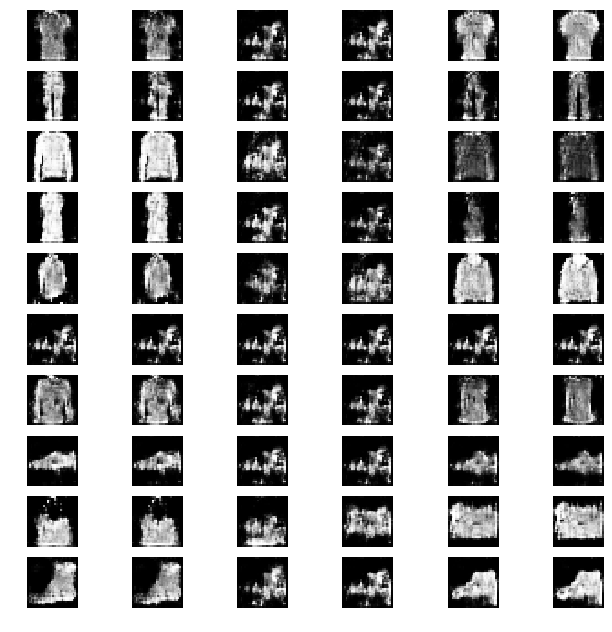

In [15]:
np.random.seed(seed=42)
#get a random point
noise_1 = np.random.normal(0, 1, (1, 100))
#draw samples between that point, and that same point with all coordinates scaled by -1
show_interp_samples(noise_1, -noise_1, 4, input_classes)

In the previous image we have 10 rows (one per class), and 6 columns (2 for the extreme points, and 4 interpolated points in the middle). 
The output for the sandal class is quite poor, and the output or the third and fourth columns is also very poor, probably because for these two colums many coordinates will be around 0, and during training the AC-GAN is not fed with points following that distribution. It can also be seen better quality outputs for the first, second, fifth and sixth columns. There are no abrupt changes at first sight either. To fix the issue around the 0s region, let's interpolate intermediate inputs from two arbitrary points.

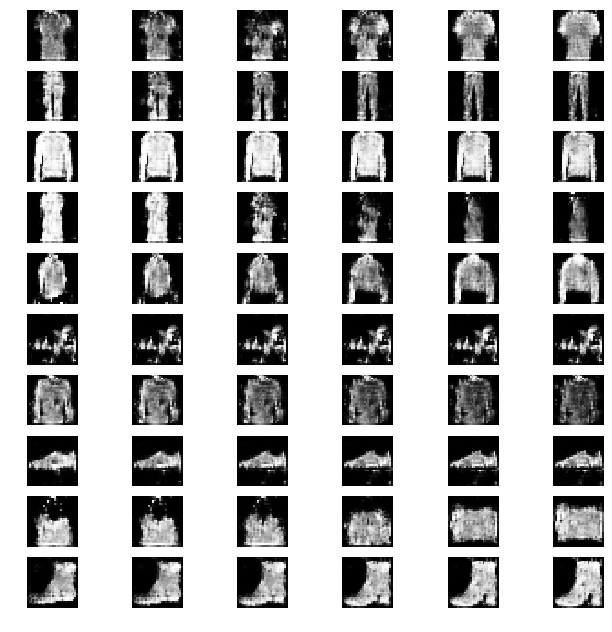

In [16]:
#draw another arbitrary point
noise_2 = np.random.normal(0, 1, (1, 100))
#draw samples between these two arbitrary points
show_interp_samples(noise_1, noise_2, 4, input_classes)

### L1 distance evaluation

Now, let's get another generated image, and see whether if it is a copy from any training image.

In [17]:
id_label_sample = 8
#yet another noise sample
yan = np.random.normal(0, 1, (1, 100))
img_smp = fashion_acgan.generator.predict([yan, np.array(id_label_sample).reshape(1, )])[0, :, :, 0]
img_smp = img_smp*0.5 + 0.5

In [18]:
def plot_n_closest(img_smp, id_label_sample, X_train, N_closest, fig_size=(8, 3)):
    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==id_label_sample)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]
    
    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    #plt.imshow(X_lab[idx_l1_sort[0], :, :], cmap='gray')
    fig, axs = plt.subplots(1, N_closest, figsize=fig_size)
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')
    plt.show()

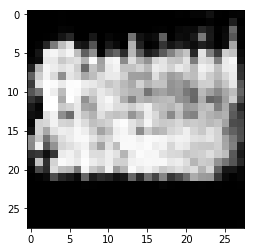

In [19]:
#original image
plt.imshow(img_smp, cmap='gray')

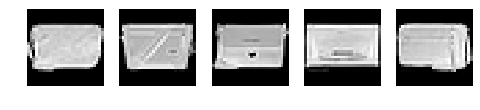

In [20]:
plot_n_closest(img_smp, 8, X_train, 5, fig_size=(8, 8))

We can visually asses, that the generated images similar to the closest ones, without being an exact copy as well.